In [ ]:
from torch import nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms.functional import crop
import cv2
import matplotlib.pyplot as plt
import time
import torch
from torch.nn import *

In [ ]:
def crop_r(image):
    return crop(image, 4, 124, 124, 124)
    
def crop_l(image):
    return crop(image, 4, 4, 124, 124)  
    
transform_right = transforms.Compose(
    [
        transforms.Resize((256,256)),
        #transforms.RandomRotation(10),
        transforms.Lambda(crop_r),
        transforms.ToTensor(),
        transforms.Normalize((0.36, 0.36, 0.36), (0.28, 0.28, 0.28))
    ])
transform_left = transforms.Compose(
    [
        transforms.Resize((256,256)),
        #transforms.RandomRotation(10),
        transforms.Lambda(crop_l),
        transforms.ToTensor(),
        transforms.Normalize((0.36, 0.36, 0.36), (0.28, 0.28, 0.28))
    ])

In [ ]:
train_path = '/content/drive/MyDrive/Datasets/KITTI/05'
batch_size = 1

train_r = datasets.ImageFolder(train_path, transform_right)
train_l = datasets.ImageFolder(train_path, transform_left)

train_loader_r = torch.utils.data.DataLoader(train_r, batch_size)
train_loader_l = torch.utils.data.DataLoader(train_l, batch_size)


In [ ]:
model = models.vgg16(pretrained=True)
layer = 0
for c in model.children():
  layer += 1
  if layer < 3:
    for param in c.parameters():
      param.requires_grad = False

model_weights =[]
conv_layers = []
model_children = list(model.children())
counter = 0
cl = [0,2,5,7,10,12,14,17,19,21,24,26,28]
for i in range(len(model_children)):
    if type(model_children[i]) == nn.modules.container.Sequential:
        print('ok')
        for j in range(len(model_children[i])):
            
            if type(model_children[i][j]) == Conv2d:
                print(model_children[i][j])
                counter+=1
                model_weights.append(model_children[i][j].weight)
                conv_layers.append(model_children[i][j])
print(f"Total convolution layers: {counter}")
print("conv_layers")

top1 = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1000, bias=True)
)

top2 = nn.Sequential(
    nn.Linear(in_features=4096, out_features=256, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(in_features=256, out_features=2, bias=True),
)

model.classifier = top1
model.classifier[6] = top2
model

ok
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ok
Total convolution layers: 13
conv_layers


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
PATH = '/content/drive/MyDrive/office_gazebo_v7/model.pt'
#model = LoopClosure()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
def rightpt(train_loader_r, min_, max_, aux_):
  for i, data in enumerate(train_loader_r):
      if i > min_:
        inputs, labels = data
        output1 = torch.flatten(model.avgpool(model.features(inputs)),1)
        outputs = model.classifier[6][0](model.classifier[5](model.classifier[4](model.classifier[3](model.classifier[2](model.classifier[1](model.classifier[0](output1)))))))
        output_.append(outputs)
        if i > max_:
          return output_


In [ ]:
def leftpt(train_loader_l, min_, max_, aux_,output_):
  for i,data in enumerate(train_loader_l):
    if i > min_:
      inputs, labels = data
      output1 = torch.flatten(model.avgpool(model.features(inputs)),1)
      outputs = model.classifier[6][0](model.classifier[5](model.classifier[4](model.classifier[3](model.classifier[2](model.classifier[1](model.classifier[0](output1)))))))
      output_[i-aux_] = torch.cat((output_[i-aux_], outputs), 1)
      if i > max_:
          return output_
           

In [ ]:
for n_it in range(1,28):
  output_ = []
  output_new = []
  try:
    if n_it == 1:
      min_ = 0
    else:
      min_ = (n_it-1)*200
    max_ = n_it*200
    aux_ = min_ +1
    output_ = rightpt(train_loader_r, min_, max_, aux_)
    output_new = leftpt(train_loader_l, min_, max_, aux_, output_)
    out_path = '/content/drive/MyDrive/Datasets/tensors_kitti_05_vgg16/tensors'+str(n_it)+'.pt'
    torch.save(output_new,out_path)
  except:
    print('error')


error


In [ ]:
def match(cam_img, db_img, dist_limit):
    distance = torch.cdist(cam_img, db_img, p=2)
    max_dist = torch.max(distance)
    if max_dist <= dist_limit:
        return True
    
    return False

In [ ]:
def belief_generation(db, descriptor):
    belief = []
    lp = 0
    for d in db:
        bg = match(descriptor, d, 4)
        if bg:
            belief.append(1)
        else:
            belief = []
        if len(belief) >= 3:
            print('loop')
            print(d)
            lp += 1
    return lp

In [ ]:
database = [database1,database2,database3,database4,database5,database6,database7,database8,database9,database10,
            database11,database12,database13,database14,database15,database16,database17,database18,database19,database20,
            database21,database22,database23,database24,database25,database26,database27]
d = []

In [ ]:
co = 0
for bg in database:
  co += 1
  for i,data in enumerate(bg):
    if i < 3:
      d.append(data)
    else:
      loop_ = belief_generation(d, data)
      with open('/content/drive/MyDrive/Datasets/KITTI/loop_kitti_05_vgg16_v3.txt', 'a') as txt_file:
        if loop_ > 0:
          txt_file.write('Found loop')
          image_number = round(((co*200)+i)/2,0)
          txt_file.write('\n image: '+str(image_number))
          txt_file.write('\n')
        else:
          d.append(data)



A saída de streaming foi truncada nas últimas 5000 linhas.
         -1.3371e-03, -3.0124e-01, -4.3055e-02, -1.5073e-01, -1.4607e-01,
         -1.1890e-01, -3.1643e-01, -2.2050e-01, -2.5357e-01, -3.8955e-01,
          4.6363e-01, -3.4006e-02, -8.4845e-01, -1.3697e-02, -2.1993e-01,
         -1.6092e-01, -5.9041e-02,  1.7310e-02, -4.2638e-02, -5.2443e-02,
         -3.0861e-02, -1.6631e-01,  5.9780e-03, -2.3639e-01, -5.7386e-01,
          1.9486e-02,  2.5769e-01, -2.0158e-01,  1.2788e-01, -1.8420e-01,
          6.4329e-02, -1.2065e-01, -2.9355e-01, -9.7739e-02, -1.6054e-01,
         -1.7073e-01, -6.4793e-01, -2.1238e-01, -1.5953e-01, -2.0339e-01,
         -6.4077e-03, -1.3661e-01, -4.4303e-02, -1.4318e-01, -5.0161e-02,
          7.1073e-01, -9.6628e-02,  5.7808e-02, -4.6511e-01, -2.5341e-01,
         -1.0965e-01, -1.2344e-01, -1.1904e-01,  3.0966e-01, -1.7942e-02,
         -2.8199e-01, -1.7133e-01, -7.1639e-02, -1.2188e-02, -3.3779e-01,
         -6.1586e-01,  3.6148e-01,  3.1210e-02, -1.83

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Datasets/metricas/kitti_05_vgg16_v1.csv')


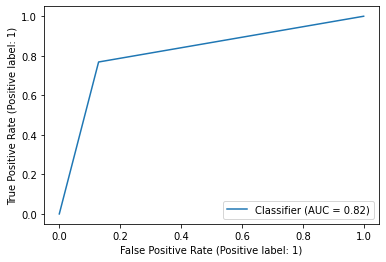

In [ ]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


RocCurveDisplay.from_predictions(df['actual'], df['pred'])
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


print('AUC: ',roc_auc_score(df['actual'], df['pred']))
print('Accuracy: ',accuracy_score(df['actual'], df['pred']))
print('f1: ',f1_score(df['actual'], df['pred']))


AUC:  0.8197102907620138
Accuracy:  0.858384643245201
f1:  0.5698569856985699


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df['actual'], df['pred'])

array([[2111,  313],
       [  78,  259]])